In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from estimator import classical_weights, V1_inspired_weights

In [2]:
from mnist import MNIST
mndata = MNIST('./data/mnist/')
train, train_labels = map(torch.FloatTensor, mndata.load_training())
test, test_labels = map(torch.FloatTensor, mndata.load_testing())
X_train = train/255.0
X_test = test/255.0

n, d = X_train.shape

y_train = train_labels.to(dtype=torch.long)
y_test = test_labels.to(dtype=torch.long)

In [3]:
class V1_net(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(d, hidden_size)
        self.fc1.weight.data = torch.FloatTensor(V1_inspired_weights(hidden_size, d, t=5, l=2, random_state=None))
        self.output = nn.Linear(hidden_size, 10)
        
    def forward(self, inputs):
        x = torch.relu(self.fc1(inputs))
        return self.output(x)
    
class He_net(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(d, hidden_size)
        torch.nn.init.kaiming_normal_(self.fc1.weight)
        self.output = nn.Linear(hidden_size, 10)
        
    def forward(self, inputs):
        x = torch.relu(self.fc1(inputs))
        return self.output(x)
    
class RF_net(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(d, hidden_size)
        self.fc1.weight.data = torch.FloatTensor(classical_weights(hidden_size, d, random_state=None))
        self.output = nn.Linear(hidden_size, 10)
        
    def forward(self, inputs):
        x = torch.relu(self.fc1(inputs))
        return self.output(x)

In [4]:
def predict(model, X):
    return model(X).data.max(1)[1]

def error(model, X, y):
    y_pred = predict(model, X)
    accuracy = 1.0 * torch.sum(y_pred == y) / len(y)
    return 1 - accuracy

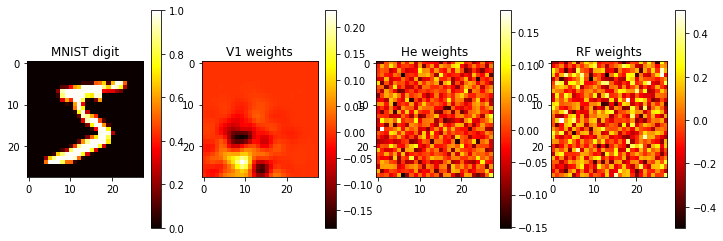

In [5]:
hidden_size = 32
V1_model = V1_net(hidden_size)
He_model = He_net(hidden_size)
RF_model= RF_net(hidden_size)

i = 4
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(141)
plt.imshow(X_train[0].reshape(28, 28), cmap='hot')
plt.title('MNIST digit')
plt.colorbar()

ax = fig.add_subplot(142)
plt.imshow(V1_model.fc1.weight.data[i].reshape(28, 28), cmap='hot')
plt.title('V1 weights')
plt.colorbar()

ax = fig.add_subplot(143)
plt.imshow(He_model.fc1.weight.data[i].reshape(28, 28), cmap='hot')
plt.title('He weights')
plt.colorbar()

ax = fig.add_subplot(144)
plt.imshow(RF_model.fc1.weight.data[i].reshape(28, 28), cmap='hot')
plt.title('RF weights')
plt.colorbar()

In [6]:
print('V1', torch.mean(torch.norm(V1_model.fc1.weight.data, dim=1)))
print('He', torch.mean(torch.norm(He_model.fc1.weight.data, dim=1)))
print('RF', torch.mean(torch.norm(RF_model.fc1.weight.data, dim=1)))

V1 tensor(1.0000)
He tensor(1.4057)
RF tensor(4.9480)


In [ ]:
h = np.random.randint(300, 500)
models = {'V1': V1_net, 'RF': RF_net}
loss_func = nn.CrossEntropyLoss()

lr = np.random.uniform(0.01, 0.1)
n_epochs = 200
n_trials = 5

train_err = {m: np.zeros((n_trials, n_epochs)) for m in models.keys()}
test_err = {m: np.zeros((n_trials, n_epochs)) for m in models.keys()}
loss_list = {m: np.zeros((n_trials, n_epochs)) for m in models.keys()}
for m, network in models.items():
    for i in range(n_trials):
        model = network(h)
        optim = torch.optim.SGD(model.parameters(), lr=lr)
        for j in range(n_epochs):
            optim.zero_grad()
            loss = loss_func(model(X_train), y_train)
            loss.backward()
            optim.step()

            train_err[m][i, j] = error(model, X_train, y_train)
            test_err[m][i, j] = error(model, X_test, y_test)
            loss_list[m][i, j] = loss.data
        
            if (j % 20 == 0):
                print('Trial %d, Epoch: %d, %s model Loss=%0.3f, test err=%0.3f' % (i,j, m, loss, test_err[m][i, j]))
avg_train_err = {m: np.mean(train_err[m], axis=0) for m in train_err.keys()}
avg_test_err = {m: np.mean(test_err[m], axis=0) for m in test_err.keys()}
avg_loss_list = {m: np.mean(loss_list[m], axis=0) for m in loss_list.keys()}

std_train_err = {m: np.std(train_err[m], axis=0) for m in train_err.keys()}
std_test_err = {m: np.std(test_err[m], axis=0) for m in test_err.keys()}
std_loss_list = {m: np.std(loss_list[m], axis=0) for m in loss_list.keys()}

In [ ]:
fig = plt.figure(figsize=(12, 5))
plt.suptitle('Shallow FFW FC net w/ SGD. h=%d, lr=%0.4f, div by norm'%(h, lr), fontsize=16)
ax = fig.add_subplot(131)
plt.title('Network loss', fontsize=16)
plt.plot(np.arange(n_epochs), avg_loss_list['V1'], label='V1-inspired', lw=3)
plt.plot(np.arange(n_epochs), avg_loss_list['RF'], label='classical', lw=3)
plt.fill_between(np.arange(n_epochs), avg_loss_list['V1'] - std_loss_list['V1'], 
                 avg_loss_list['V1'] + std_loss_list['V1'], alpha=0.2)
plt.fill_between(np.arange(n_epochs), avg_loss_list['RF'] - std_loss_list['RF'], 
                 avg_loss_list['RF'] + std_loss_list['RF'], alpha=0.2)



plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Training loss', fontsize=20)
ax.tick_params(axis = 'both', which = 'major', labelsize = 14, width=2, length=6)
plt.legend(fontsize=18)

ax = fig.add_subplot(132)
plt.title('Train error', fontsize=16)
plt.plot(np.arange(n_epochs), avg_train_err['V1'], label='V1-inspired', lw=3)
plt.plot(np.arange(n_epochs), avg_train_err['RF'],  label='classical', lw=3)
plt.fill_between(np.arange(n_epochs), avg_train_err['V1'] - std_train_err['V1'], 
                 avg_train_err['V1'] + std_train_err['V1'],  alpha=0.2 )
plt.fill_between(np.arange(n_epochs), avg_train_err['RF'] - std_train_err['RF'], 
                 avg_train_err['RF'] + std_train_err['RF'],  alpha=0.2 )
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Training error', fontsize=20)
ax.tick_params(axis = 'both', which = 'major', labelsize = 14, width=2, length=6)
plt.yticks(np.arange(0, 1, 0.2))
plt.legend(fontsize=18)

ax = fig.add_subplot(133)
plt.title('Test error', fontsize=16)
plt.plot(np.arange(n_epochs), avg_test_err['V1'], label='V1-inspired', lw=3)
plt.plot(np.arange(n_epochs), avg_test_err['RF'], label='classical', lw=3)
plt.fill_between(np.arange(n_epochs), avg_test_err['V1'] - std_test_err['V1'], 
                 avg_test_err['V1'] + std_test_err['V1'], alpha=0.2 )
plt.fill_between(np.arange(n_epochs), avg_test_err['RF'] - std_test_err['RF'], 
                 avg_test_err['RF'] + std_test_err['RF'], alpha=0.2 )
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Test error', fontsize=20)
ax.tick_params(axis = 'both', which = 'major', labelsize = 14, width=2, length=6)
plt.yticks(np.arange(0, 1, 0.2))
plt.legend(fontsize=18)
                                       
plt.tight_layout()
plt.subplots_adjust(top=0.8)
plt.savefig('results/initialize_mnist/init_h=%d_lr=%0.3f.png'%(h, lr))

In [ ]:
fig = plt.figure()
plt.imshow(model.fc1.weight.data[22].reshape(28, 28), cmap='hot')

In [ ]:
W = V1_inspired_weights(20, 784, 5, 3)
fig = plt.figure()
plt.imshow(W[0].reshape(28, 28), cmap='hot')
plt.colorbar()